# Отбор коров для молочного хозяйства с помощью линейных моделей машинного обучения

## Описание задачи и цели работы

В рамках этого проекта необходимо автоматизировать отбор коров для покупки владельцем молочной фермы. Цель — с помощью моделей машинного обучения предсказать два ключевых показателя:  
- возможный годовой удой молока от каждой коровы,
- вероятность того, что молоко будет признано вкусным по субъективной оценке фермера.

Это позволит минимизировать риски и выбрать животных, которые помогут выполнить производственный план (удой не менее 6000 кг в год) и обеспечить высокое качество продукта.

В ходе работы будут:
- проведён анализ и подготовка данных по стаду,
- построены и сравнены несколько моделей линейной регрессии и классификации,
- даны практические рекомендации для принятия решений о покупке коров.

### Импорт необходимых библиотек

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

## Загрузка данных

### 1.1

In [57]:
fm = pd.read_csv("/datasets/ferma_main.csv", sep=';', decimal = ',')
fd = pd.read_csv("/datasets/ferma_dad.csv", sep=';', decimal = ',')
cb = pd.read_csv("/datasets/cow_buy.csv", sep=';', decimal = ',')

In [58]:
fm.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


In [59]:
fd.head()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [60]:
cb.head()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


### 1.2

В названии некоторых столбцов вместо пробела стоит `_`, будет произведена замена символа `_` на пробел, также все названия стобцов во всех файлах будут приведены к нижнему регистру

In [61]:
fm.columns = fm.columns.str.replace('_', ' ')
fm.columns = fm.columns.str.lower()

fd.columns = fd.columns.str.lower()

cb.columns = cb.columns.str.replace('_', ' ')
cb.columns = cb.columns.str.lower()

##  Предобработка данных

### 2.1

In [62]:
fm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   удой, кг                               634 non-null    int64  
 2   эке (энергетическая кормовая единица)  634 non-null    float64
 3   сырой протеин, г                       634 non-null    int64  
 4   спо (сахаро-протеиновое соотношение)   634 non-null    float64
 5   порода                                 634 non-null    object 
 6   тип пастбища                           634 non-null    object 
 7   порода папы быка                       634 non-null    object 
 8   жирность,%                             634 non-null    float64
 9   белок,%                                634 non-null    float64
 10  вкус молока                            634 non-null    object 
 11  возрас

**В столбцах `эке (энергетическая кормовая единица)`, `спо (сахаро-протеиновое соотношение)`, `жирность %`, `белок %` данные хранятся в качестве `object`, а должны быть в качестве `float`, также вместо `.` используется `,` для разделения целой и дробной частей, что некорректно для `Python`, поэтому будет проведена замена `,` на `.`**

In [63]:
display("Дубликатов в fm -", fm.duplicated().sum())
display("Пропусков в fm -", fm.isna().sum())
display('Неявные дубликаты в fm -', fm['тип пастбища'].value_counts(), fm['порода папы быка'].value_counts(), 
        fm['вкус молока'].value_counts(), fm['возраст'].value_counts())

'Дубликатов в fm -'

5

'Пропусков в fm -'

id                                       0
удой, кг                                 0
эке (энергетическая кормовая единица)    0
сырой протеин, г                         0
спо (сахаро-протеиновое соотношение)     0
порода                                   0
тип пастбища                             0
порода папы быка                         0
жирность,%                               0
белок,%                                  0
вкус молока                              0
возраст                                  0
dtype: int64

'Неявные дубликаты в fm -'

Холмистое    356
Равнинное    253
Равнинные     25
Name: тип пастбища, dtype: int64

Соверин    316
Айдиал     240
Айдиалл     78
Name: порода папы быка, dtype: int64

вкусно       371
не вкусно    263
Name: вкус молока, dtype: int64

более_2_лет    524
менее_2_лет    110
Name: возраст, dtype: int64

**В датафрейме `fm` обнаружено 2 неявных дубликата, 5 явных дубликатов и ни одного пропуска**

**Устраним проблемы с типами данных и дубликатами в `fm`:**

In [64]:
fm['эке (энергетическая кормовая единица)'] = fm['эке (энергетическая кормовая единица)'].astype('float')

fm['спо (сахаро-протеиновое соотношение)'] = fm['спо (сахаро-протеиновое соотношение)'].astype('float')

fm['тип пастбища'] = fm['тип пастбища'].str.replace('Равнинные', 'Равнинное')
fm['порода папы быка'] = fm['порода папы быка'].str.replace('Айдиалл', 'Айдиал')

fm['жирность,%'] = fm['жирность,%'].astype('float')

fm['белок,%'] = fm['белок,%'].astype('float')

In [65]:
fm = fm.drop_duplicates()

<br/>
<div class="alert alert-info">
Может я что-то не так понял, но по-моему в fm я снчала обработал неявные, а потом уже применил drop_duplicates, если не в этом дело, можешь ли ты поподробнее расскрыть проблему?
</div>

**Проблемы с данными в датафрейме `fm` устранены**

In [66]:
fd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   имя папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


**Все в порядке, `id` это целое число(номер), а имя должно быть строковым типом данных.**

In [67]:
display('Дубликаты', fd.duplicated().sum())
display('Пропуски', fd.isna().sum())

'Дубликаты'

0

'Пропуски'

id          0
имя папы    0
dtype: int64

**Ни одного пропуска или дубликата, датафрейм `fd` полностью в порядке**

In [68]:
cb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   порода                   20 non-null     object 
 1   тип пастбища             20 non-null     object 
 2   порода папы быка         20 non-null     object 
 3   имя папы                 20 non-null     object 
 4   текущая жирность,%       20 non-null     float64
 5   текущий уровень белок,%  20 non-null     float64
 6   возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**В колонках `текущая жирность,%` и `текущий уровень белок,%` вместо вещественного типа данных `float`, данные хранятся в качестве строк `object`**

In [69]:
display('Дубликаты', cb.duplicated().sum())
display('Пропуски', cb.isna().sum())
display('Неявные дубликаты -', cb['порода'].value_counts(), cb['тип пастбища'].value_counts(),
        cb['порода папы быка'].value_counts(), cb['возраст'].value_counts())

'Дубликаты'

4

'Пропуски'

порода                     0
тип пастбища               0
порода папы быка           0
имя папы                   0
текущая жирность,%         0
текущий уровень белок,%    0
возраст                    0
dtype: int64

'Неявные дубликаты -'

РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: порода, dtype: int64

равнинное    11
холмистое     9
Name: тип пастбища, dtype: int64

Соверин    12
Айдиал      8
Name: порода папы быка, dtype: int64

более_2_лет    15
менее_2_лет     5
Name: возраст, dtype: int64

**Всего 4 дубликата и ниодного пропсука**

**Устраним выявленные проблемы:**

In [70]:
cb['текущая жирность,%'] = cb['текущая жирность,%'].astype('float')
cb['текущий уровень белок,%'] = cb['текущий уровень белок,%'].astype('float')

In [71]:
cb = cb.drop_duplicates()

**Проблемы с датафреймом `cb` устранены**

## Исследовательский анализ данных

### 3.1 Статистический анализ

In [72]:
fm.describe()

,id,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),"жирность,%","белок,%"
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


In [73]:
cb.describe()

,"текущая жирность,%","текущий уровень белок,%"
count,16.000000,16.000000
mean,3.571875,3.068250
std,0.141620,0.011264
min,3.340000,3.046000
25%,3.415000,3.059500
50%,3.585000,3.073500
75%,3.692500,3.076750
max,3.770000,3.081000


### 3.2 Графики

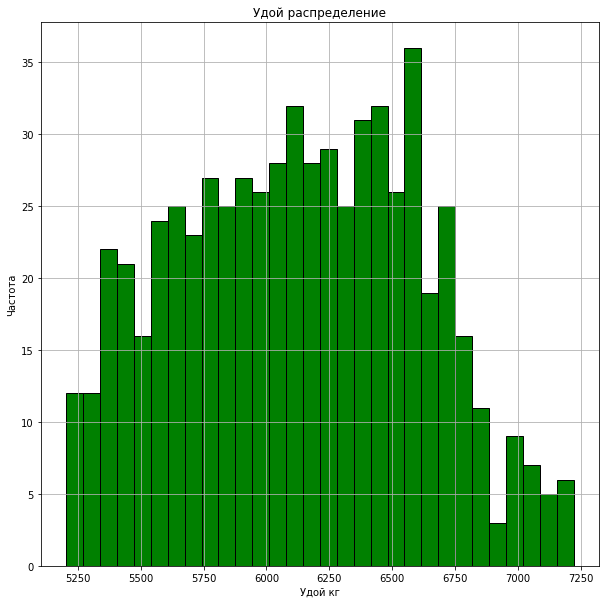

In [74]:
fm = fm.loc[fm['удой, кг']<15000]
# Избавился от выбросов для большей наглядности
plt.figure(figsize=(10, 10))
plt.hist(fm['удой, кг'], bins=30, edgecolor='black', color='green')
plt.title('Удой распределение')
plt.xlabel('Удой кг')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий:** Распределение удоя имеет форму, близкую к нормальной, с пиком в диапазоне 6200–6600 кг. Большинство значений сосредоточено в пределах от 5200 до 7200 кг, выбросы за пределами этих границ были успешно исключены.

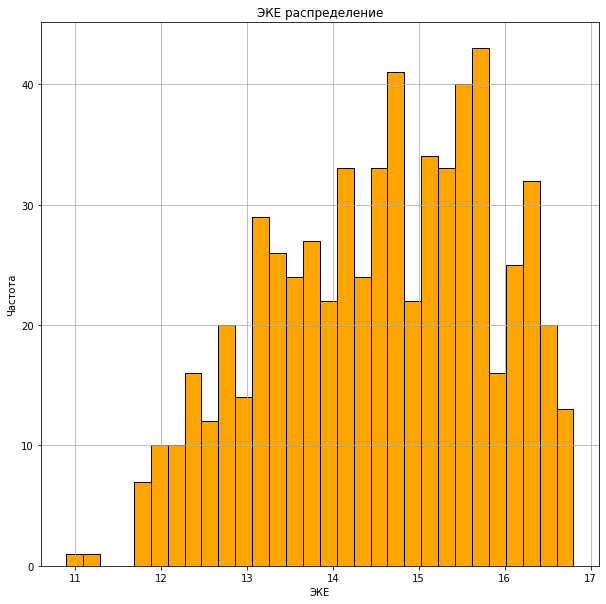

In [75]:
plt.figure(figsize=(10, 10))
plt.hist(fm['эке (энергетическая кормовая единица)'], bins=30, edgecolor='black', color='orange')
plt.title('ЭКЕ распределение')
plt.xlabel('ЭКЕ')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Распределение значений ЭКЕ смещено вправо и показывает пик в интервале от 14 до 16. Большинство значений сосредоточено в диапазоне 12–16. Выбросы и крайние значения встречаются редко.

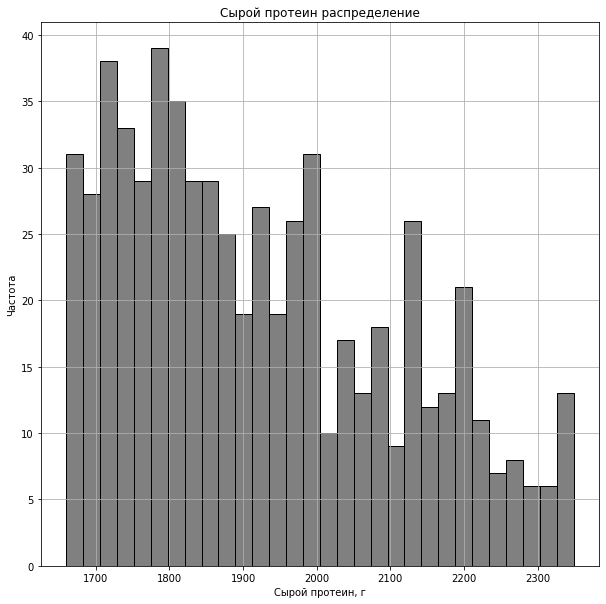

In [76]:
plt.figure(figsize=(10, 10))
plt.hist(fm['сырой протеин, г'], bins=30, edgecolor='black', color='gray')
plt.title('Сырой протеин распределение')
plt.xlabel('Сырой протеин, г')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Распределение значений сырого протеина смещено влево, больше всего значений находится в диапозоне от 1500 до 1850, по мере увелечения значения сырого протеина.

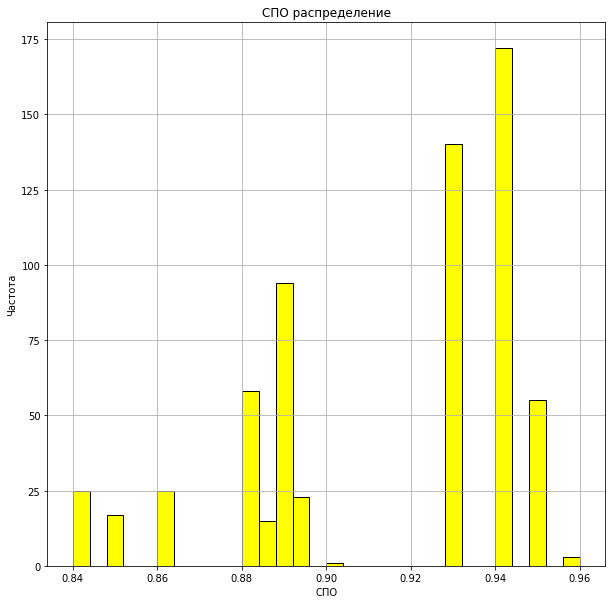

In [77]:
plt.figure(figsize=(10, 10))
plt.hist(fm['спо (сахаро-протеиновое соотношение)'], bins=30, edgecolor='black', color='yellow')
plt.title('СПО распределение')
plt.xlabel('СПО')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Коменатрий**: Распределение показателя СПО выражено неравномерно, с ярко выраженным пиком около значений 0.93–0.94.

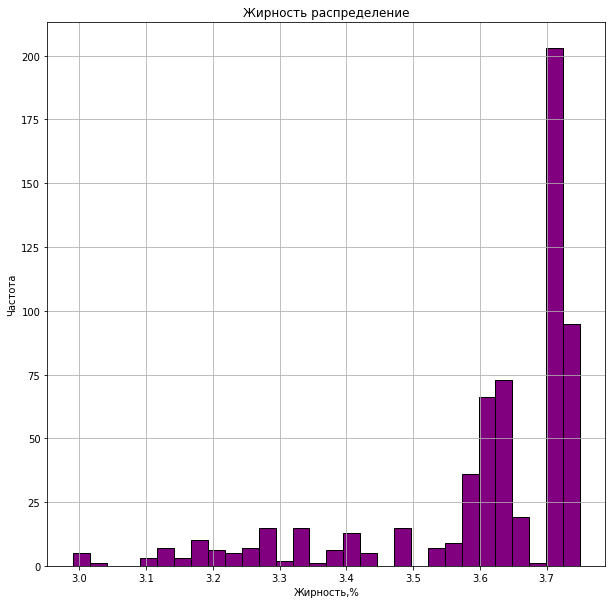

In [78]:
plt.figure(figsize=(10, 10))
plt.hist(fm['жирность,%'], bins=30, edgecolor='black', color='purple')
plt.title('Жирность распределение')
plt.xlabel('Жирность,%')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Коментарий**: Распределение жирности молока имеет чётко выраженный пик в районе 3.7%, что говорит о стандартизации или стабильности этого показателя в основной массе выборки. Небольшое количество значений ниже 3.5% указывает на редкие отклонения от нормы.

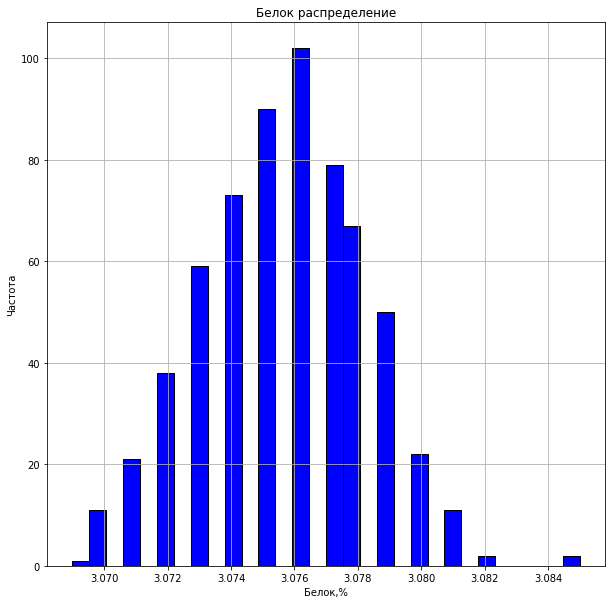

In [79]:
plt.figure(figsize=(10, 10))
plt.hist(fm['белок,%'], bins=30, edgecolor='black', color='blue')
plt.title('Белок распределение')
plt.xlabel('Белок,%')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Коментарий**: Распределение содержания белка в молоке имеет чётко выраженную симметричную форму, близкую к нормальному распределению, с максимумом около 3.076%.

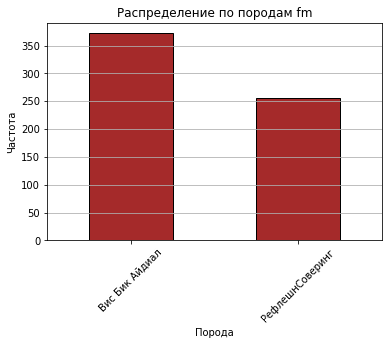

In [80]:
fm['порода'].value_counts().plot(kind='bar', color='brown', edgecolor='black')

plt.title('Распределение по породам fm')
plt.xlabel('Порода')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

**Коментарий**: График показывает, что в выборке по датафрейму fm порода «Век Бык Анапский» встречается заметно чаще (более 360 наблюдений), чем «Редденш-Северинг» (около 260).

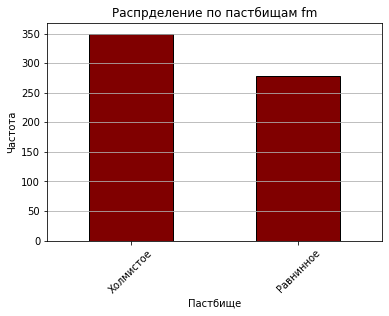

In [81]:
fm['тип пастбища'].value_counts().plot(kind='bar', color='maroon', edgecolor='black')

plt.title('Распрделение по пастбищам fm')
plt.xlabel('Пастбище')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Комментарий**: Основная часть животных содержится на холмистых пастбищах, а равнинные встречаются заметно реже, но всё ещё составляют значительную долю выборки.

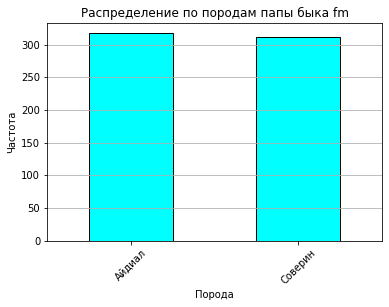

In [82]:
fm['порода папы быка'].value_counts().plot(kind='bar', color='cyan', edgecolor='black')

plt.title('Распределение по породам папы быка fm')
plt.xlabel('Порода')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Комментарий**: График показывает, что распределение по породам пап быков в выборке fm практически равномерное: породы «Анапал» и «Соверин» представлены с очень близкой частотой (примерно по 310 наблюдений каждая).

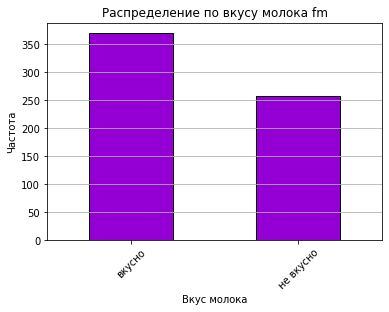

In [83]:
fm['вкус молока'].value_counts().plot(kind='bar', color='darkviolet', edgecolor='black')

plt.title('Распределение по вкусу молока fm')
plt.xlabel('Вкус молока')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Комментарий**: Распределение по вкусу молока показывает, что большинство респондентов оценили молоко как «вкусное» — более 360 случаев. Около 260 оценок дали противоположный ответ, что может указывать на наличие факторов, влияющих на вкусовое восприятие

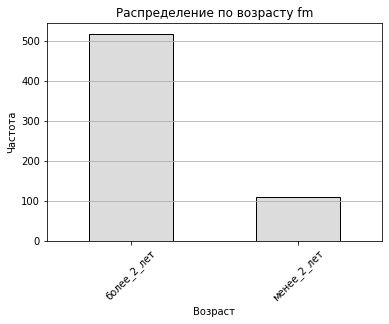

In [84]:
fm['возраст'].value_counts().plot(kind='bar', color='gainsboro', edgecolor='black')

plt.title('Распределение по возрасту fm')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

**Комментарий**: Распределение по возрасту показывает заметное преобладание животных старше 2 лет — более 500 наблюдений. Молодые особи (менее 2 лет) представлены в значительно меньшем количестве

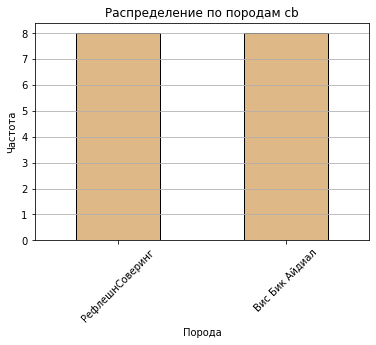

In [85]:
cb['порода'].value_counts().plot(kind='bar', color='burlywood', edgecolor='black')

plt.title('Распределение по породам cb')
plt.xlabel('Порода')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

**Комментарий**: Распределение по породам оказалось равномерным: в выборке представлены только две породы — «Век Бык Анапский» и «Редденш-Северинг», каждая из которых встречается по 8 раз.

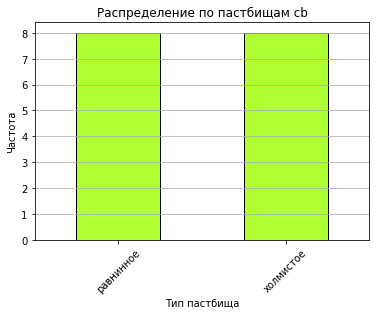

In [86]:
cb['тип пастбища'].value_counts().plot(kind='bar', color='greenyellow', edgecolor='black')

plt.title('Распределение по пастбищам cb')
plt.xlabel('Тип пастбища')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

**Комментарий**: Распределение по типам пастбищ оказалось равномерным — каждый из двух типов («равнина», «холмистость») представлен одинаково, по 8 наблюдений.

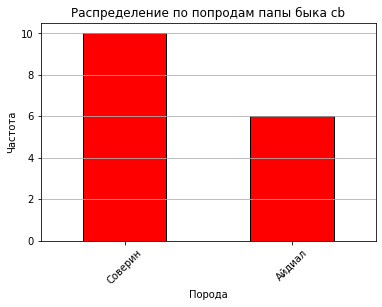

In [87]:
cb['порода папы быка'].value_counts().plot(kind='bar', color='red', edgecolor='black')

plt.title('Распределение по попродам папы быка cb')
plt.xlabel('Порода')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

**Комментарий**: Распределение по породам пап быков неравномерное: порода «Северин» встречается чаще (9 наблюдений), чем «Анапская» (5 наблюдений)

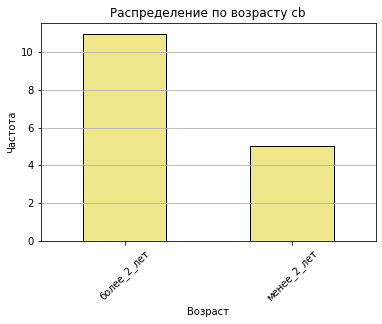

In [88]:
cb['возраст'].value_counts().plot(kind='bar', color='khaki', edgecolor='black')

plt.title('Распределение по возрасту cb')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

**Комментарий**: Распределение по возрасту показывает, что в выборке преобладают особи старше 2 лет. Молодые животные (менее 2 лет) встречаются реже, что может отражать специфику набора данных или акцент на зрелых животных

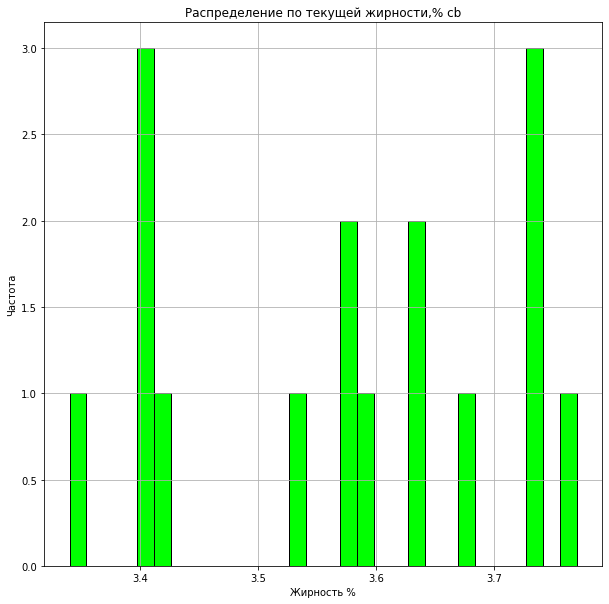

In [89]:
plt.figure(figsize=(10,10))
plt.hist(cb['текущая жирность,%'], bins=30, color='lime', edgecolor='black')
plt.title('Распределение по текущей жирности,% cb')
plt.xlabel('Жирность %')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Данных недостаточно, чтобы оценить распределение, можно лишь заметить, что выбросов нет.

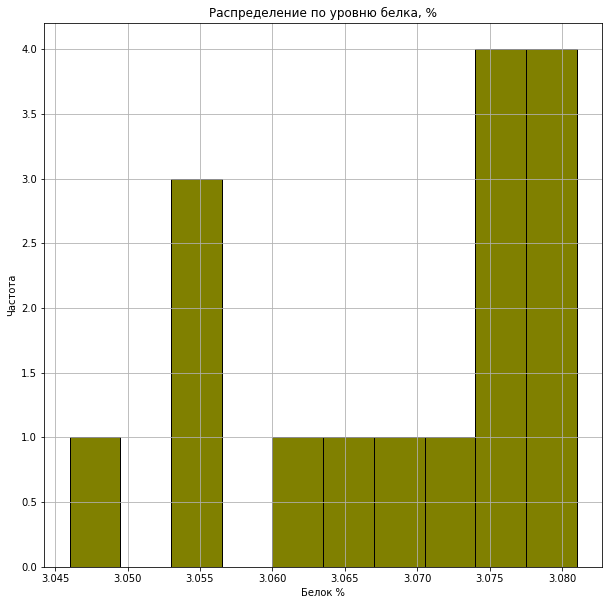

In [90]:
plt.figure(figsize=(10,10))
plt.hist(cb['текущий уровень белок,%'], color='olive', edgecolor='black')
plt.title('Распределение по уровню белка, %')
plt.xlabel('Белок %')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

**Комментарий**: Распределение уровня белка имеет слабо выраженную форму и показывает, что большинство значений сосредоточено в узком диапазоне от 3.075% до 3.080%

### 3.3 Выводы о данных

#### Выводы о данных

- В количественных признаках обнаружены выбросы (например, по удою), которые искажают распределение.
- Некоторые признаки имеют асимметричное или необычное распределение.
- В категориальных данных встречаются дублирующиеся или некорректные значения (например, «Равнинное» и «Равнинные»).

#### План по улучшению данных

- Преобразовать категориальные признаки в числовой формат.
- При необходимости — нормализовать количественные признаки.

## Корреляционный анализ

### 4.1 Рассчет корреляции между всеми признаками

In [91]:
fm.drop('id', axis=1).corr(method='spearman')

,"удой, кг",эке (энергетическая кормовая единица),"сырой протеин, г",спо (сахаро-протеиновое соотношение),"жирность,%","белок,%"
"удой, кг",1.000000,0.765144,0.437543,0.787904,0.688506,-0.005701
эке (энергетическая кормовая единица),0.765144,1.000000,0.384747,0.741962,0.686973,-0.013321
"сырой протеин, г",0.437543,0.384747,1.000000,0.485890,0.392822,0.229051
спо (сахаро-протеиновое соотношение),0.787904,0.741962,0.485890,1.000000,0.701044,0.109924
"жирность,%",0.688506,0.686973,0.392822,0.701044,1.000000,0.043125
"белок,%",-0.005701,-0.013321,0.229051,0.109924,0.043125,1.000000


**Комментарий**: Корреляционный анализ показал, что удой наиболее сильно связан с такими признаками, как энергетическая кормовая единица (r = 0.76) и сахарно-протеиновое соотношение (r = 0.79), а также с жирностью молока (r = 0.68). Содержание белка в молоке практически не влияет на удой (r ≈ 0), а остальные признаки демонстрируют умеренную связь между собой. Мультиколлинеарность(корреляция выше 0.9) не наблюдается


### 4.2 Диаграммы рассеяния

Создадим функцию для нарисования диаграммы рассеяния

In [92]:
def plot_all_scatter_by_category(df, category_col, y_col='удой, кг', x_cols=None, figsize=(8, 5)):
    if x_cols is None:
        x_cols = df.select_dtypes(include='number').columns.drop(y_col)
        
    for x in x_cols:
        plt.figure(figsize=figsize)
        sns.scatterplot(data=df, x=x, y=y_col, hue=category_col, alpha=0.7)
        plt.title(f'{y_col} и {x} по {category_col}')
        plt.xlabel(x)
        plt.ylabel(y_col)
        plt.ylim(4500, 8000)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


**Теперь применим функцию к каждому категориальному признаку `fm`**

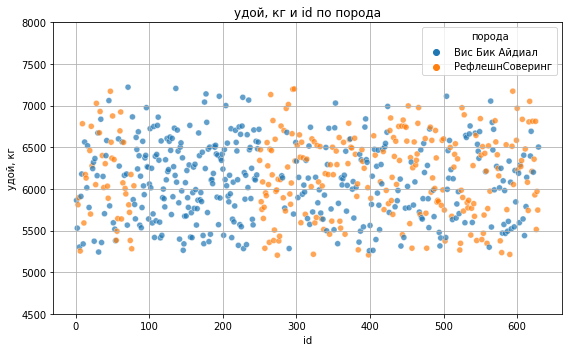

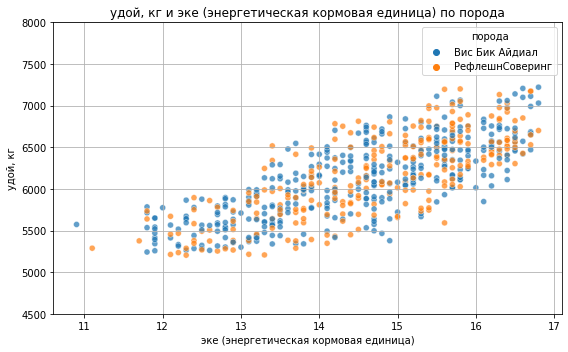

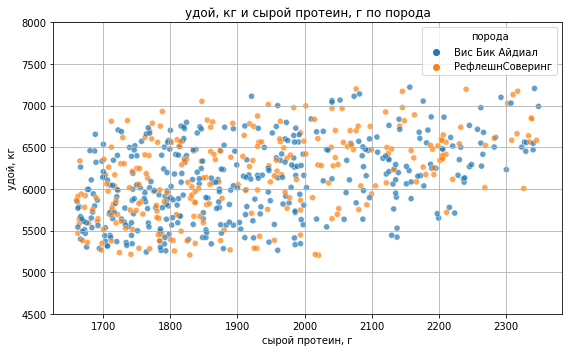

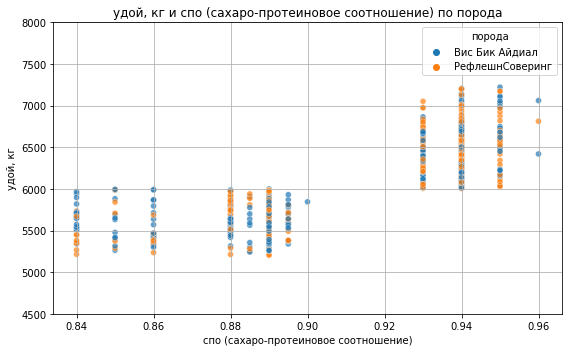

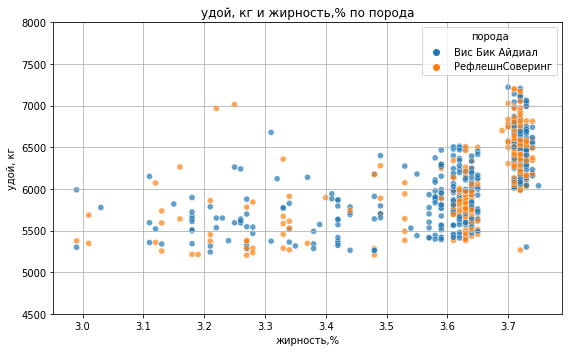

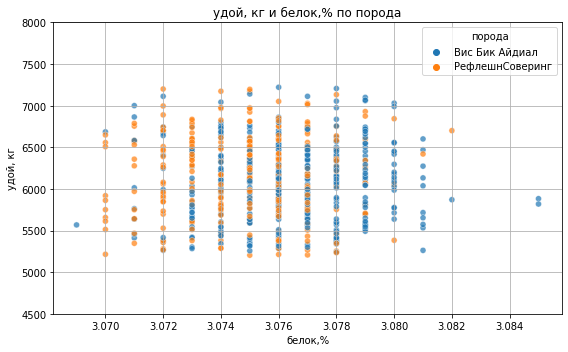

In [93]:
plot_all_scatter_by_category(fm, category_col='порода')

**Комментарий**: По всем шести диаграммам видно, что удой никак не зависит от порядкового номера записи (id), но чётко растёт с увеличением ЭКЕ, содержанием сырого протеина, сухо-протеинового соотношения и жирности, а связь с процентом белка слабее. Кроме того, точки для двух пород почти совпадают по общей тенденции, хотя «Вис Бик Айдиал» чуть чаще достигает более высоких удоев при эквивалентных значениях кормовых показателей.

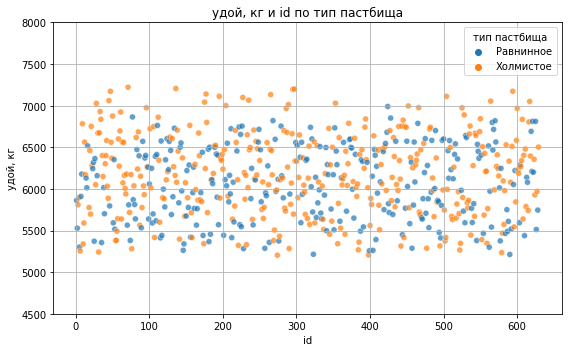

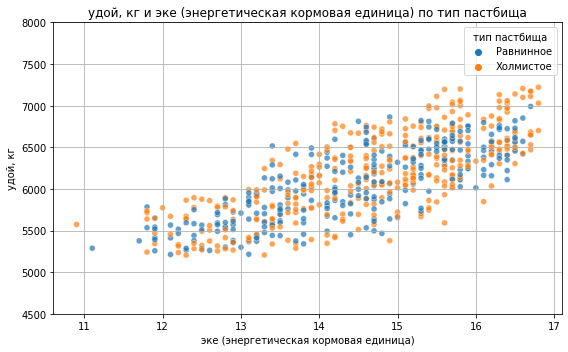

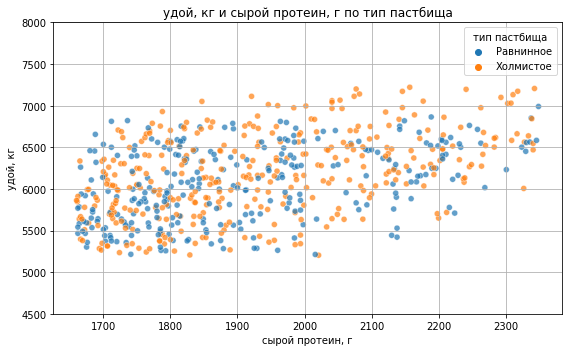

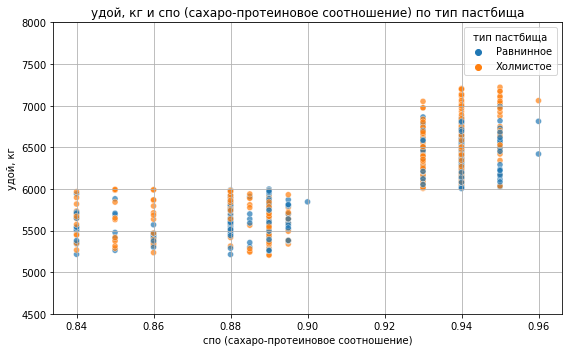

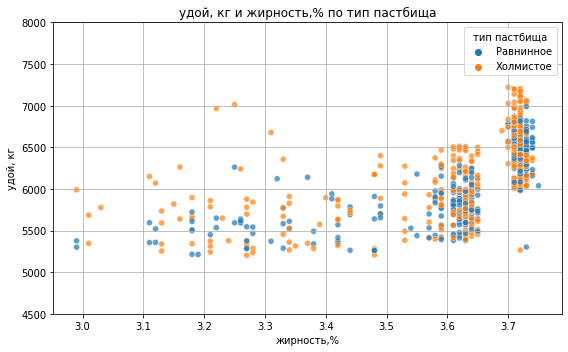

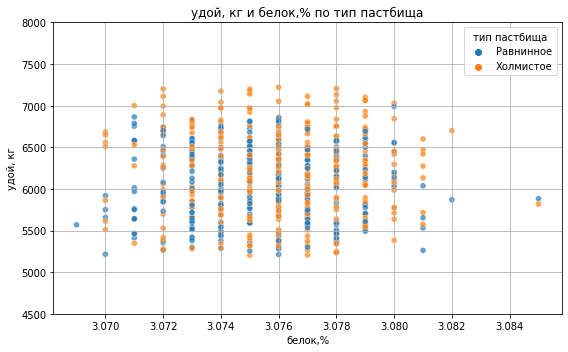

In [94]:
plot_all_scatter_by_category(fm, category_col='тип пастбища')

**Комментарий**: На всех диаграммах видно, что точки для «равнинного» и «холмистого» пастбища почти полностью совпадают, то есть тип пастбища мало влияет на связь между удоем и любым из количественных признаков. При этом удой слабо растет с увеличением сырого протеина и белка, более явно – с эке и спо, а с процентом жира связь практически отсутствует

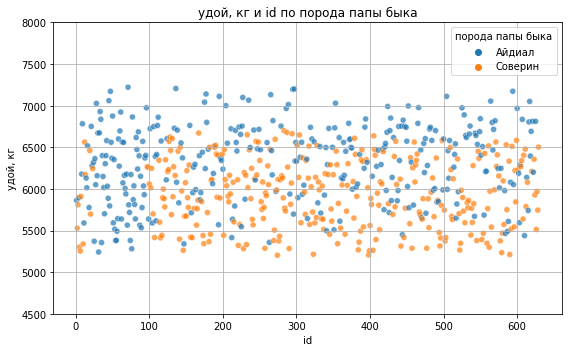

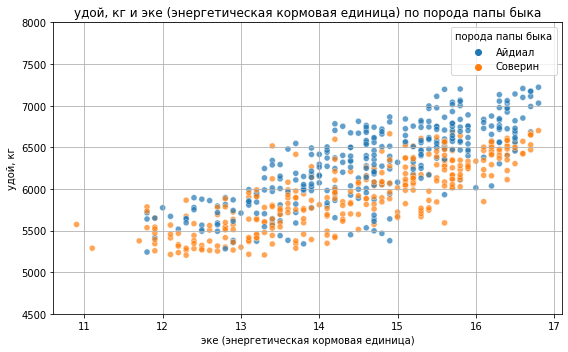

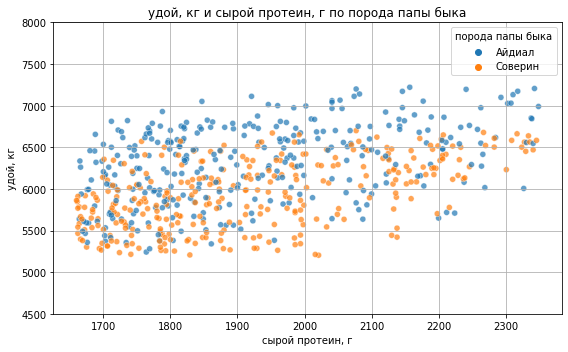

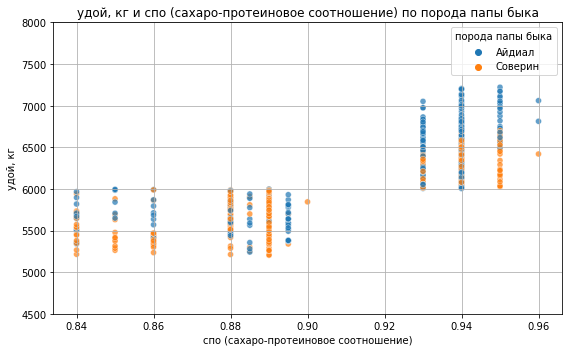

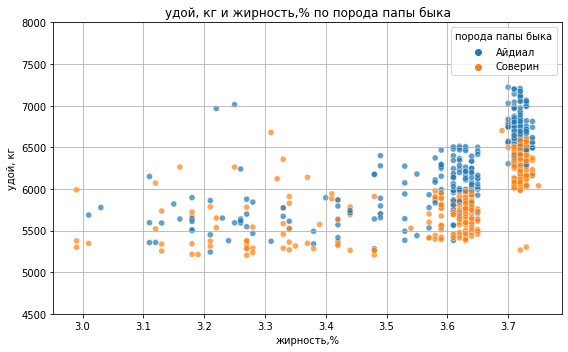

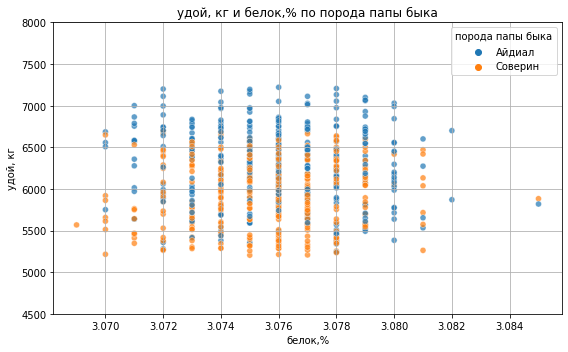

In [95]:
plot_all_scatter_by_category(fm, category_col='порода папы быка')

**Комментарий**: По всем параметрам связь «удой – признак» схожа для потомства быков обеих пород, однако на одинаковых значениях ЭКЕ, сырого протеина, СПО и жира коровы от «Айдиал» в среднем дают немного больше молока, чем от «Соверин».

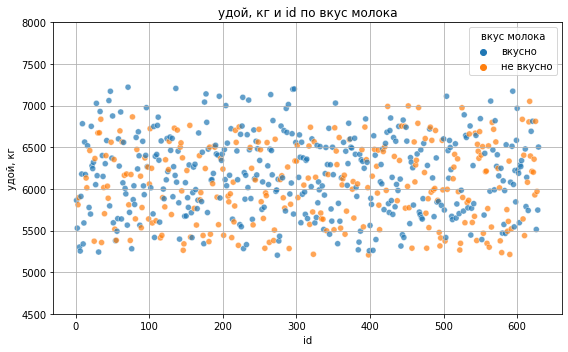

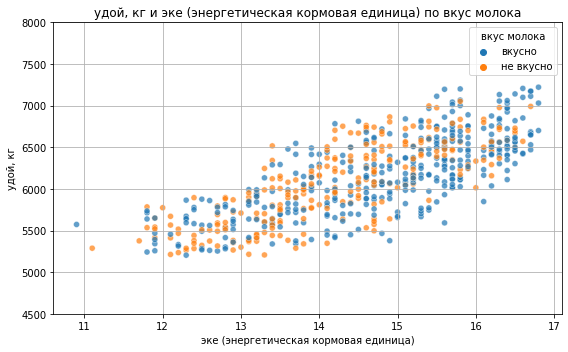

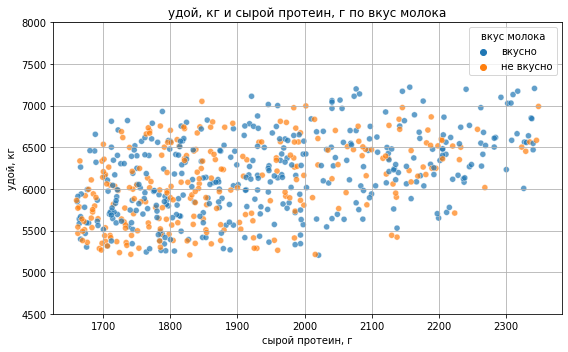

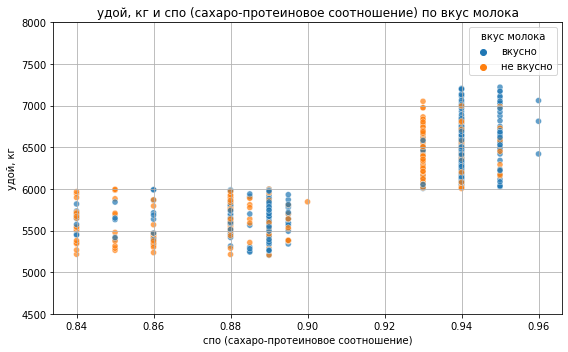

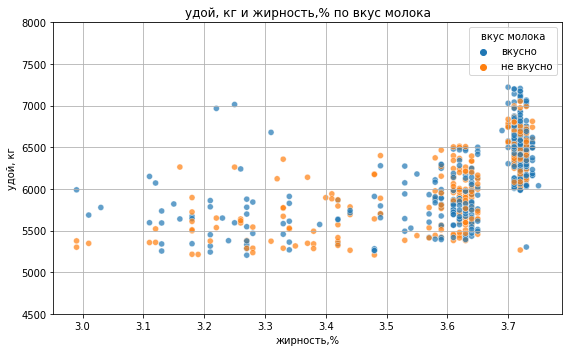

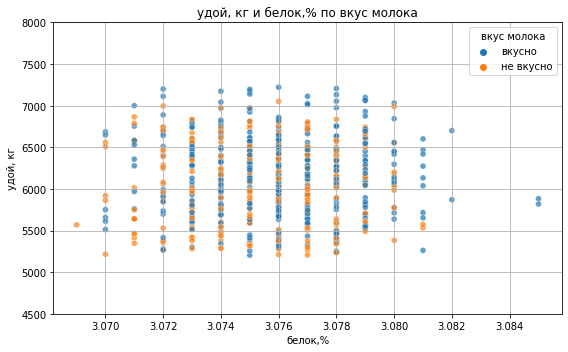

In [96]:
plot_all_scatter_by_category(fm, category_col='вкус молока')

**Комментарий**: По всем диаграммам видно, что вкус молока почти не меняет общую зависимость «удой – количественный признак»: коровы с «вкусным» и «не вкусным» молоком распределены почти одинаково. Как и раньше, наиболее сильная положительная связь наблюдается с ЭКЕ и СПО, в то время как связь с содержанием белка и вкусом молока практически отсутствует

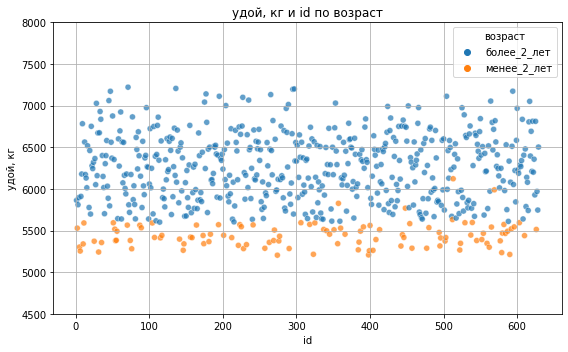

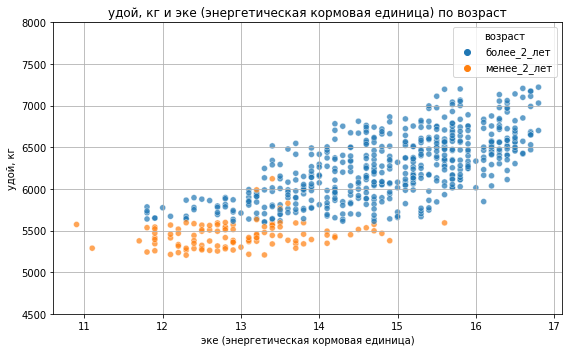

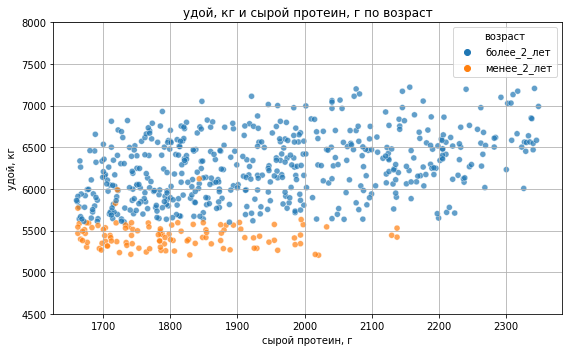

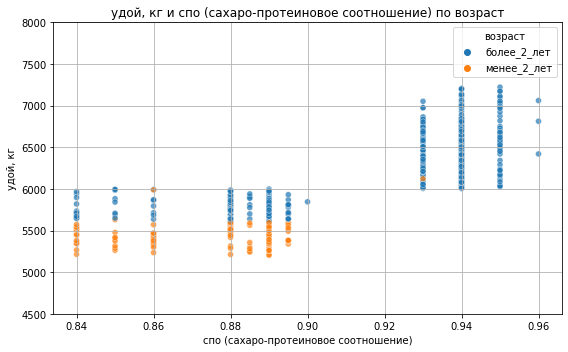

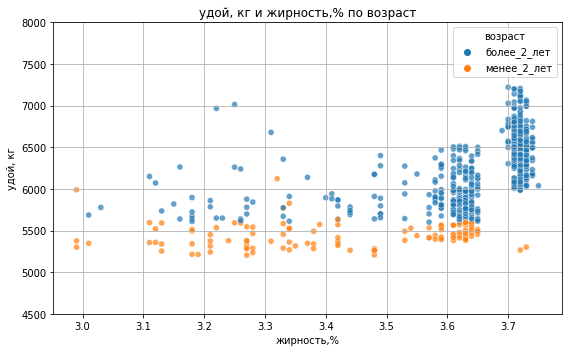

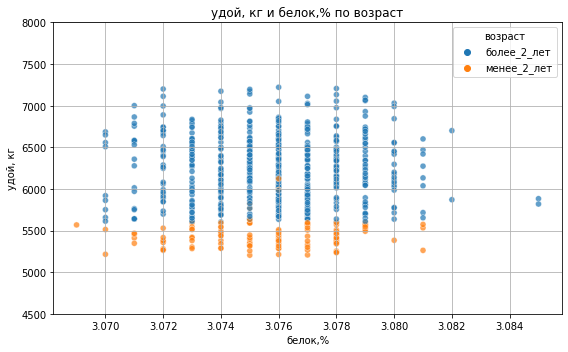

In [97]:
plot_all_scatter_by_category(fm, category_col='возраст')

**Комментарий**: На всех диаграммах молодые коровы (до 2 лет) устойчиво дают меньший удой, чем старшие (более 2 лет), но внутри каждой группы наблюдается та же чёткая положительная зависимость с ЭКЕ и СПО.

**Зависимость удоя от количественных признаков**: 
```
- ЭКЕ имеет четкую линейную зависимость
- сырой протеин имеет слабую линейную зависимость
- СПО, жирность и белок показывают тенденцию к кластеризации (нелинейная зависимость)
```

### 4.3 Вывод

#### 1. Тип взаимосвязи между целевым и входными признаками
- Между **удоем** и **ЭКЕ (энергетическая кормовая единица)** наблюдается чёткая **линейная положительная** связь: чем выше ЭКЕ, тем больше удой.
- Аналогичная линейная положительная связь прослеживается и с **СОП**.
- Связь с **сырым протеином** и с **процентом белка** также положительная, но более слабая.
- Зависимость от **процента жира** практически отсутствует.
- Категориальные признаки (тип пастбища, порода отца, вкус молока) не изменяют общую линейную тенденцию, лишь слегка смещают уровни удоя в пределах общей зависимости.
- Более молодые коровы (≤ 2 лет) дают на 500–800 кг меньше молока при прочих равных, чем старшие (> 2 лет), но внутри каждой возрастной группы все равно сохраняется линейная связь с ЭКЕ и СПО.

#### 2. Нелинейные связи
- **Явных нелинейных зависимостей** между удоем и любым из количественных признаков не обнаружено.
- Для ввода дополнительных признаков нет причин.

#### 3. Мультиколлинеарность между входными признаками
- Между **ЭКЕ**, **сырой протеином** и **СПО** наблюдается высокая корреляция.
- Но **мультиколлинеарность**, которая может влиять на стабильность коэффициентов линейной регрессии, отсутствует
---


## Обучение модели линейной регрессии

### 5.1

In [98]:
X = fm[
    [
        'эке (энергетическая кормовая единица)',
        'сырой протеин, г',
        'спо (сахаро-протеиновое соотношение)',
        'возраст',
        'порода папы быка',
        'тип пастбища',
        'порода'
    ]
]
y = fm['удой, кг']

**Пояснение выбора входных признаков**: эке, сырой протеин, спо мы берем т.к. это характеристики энергитической ценности корма, а ранее мы выяснили, что корм влияет на удой. Возраст, тип пастбища и вкус молока мы берем потому что ранее на диаграммах рассеяния было видно, что в зависимости от этих параматеров корова может давать большой или маленький удой, породу папы быка берем т.к. генетическая составляющая тоже играет роль.

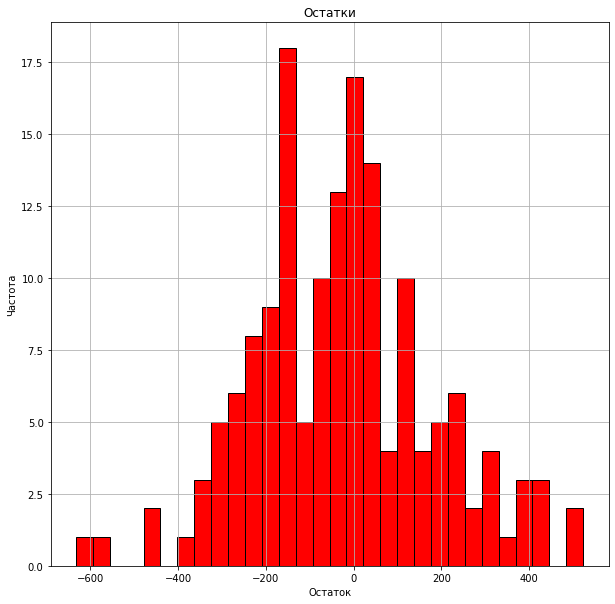

('R2 score:', 0.7097500418845586)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42
)

cat_cols = ['возраст', 'порода папы быка', 'тип пастбища', 'порода']
num_cols = [
    'эке (энергетическая кормовая единица)',
    'сырой протеин, г',
    'спо (сахаро-протеиновое соотношение)',
]

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
X_train_ohe1 = encoder.fit_transform(X_train[cat_cols])
X_test_ohe1  = encoder.transform(X_test[cat_cols])

scaler = StandardScaler()
X_train_scaled1 = scaler.fit_transform(X_train[num_cols])
X_test_scaled1  = scaler.transform(X_test[num_cols])

X_train_prepared1 = np.hstack([X_train_scaled1, X_train_ohe1])
X_test_prepared1  = np.hstack([X_test_scaled1,  X_test_ohe1])

model_lr1 = LinearRegression()
model_lr1.fit(X_train_prepared1, y_train)
y_pred1 = model_lr1.predict(X_test_prepared1)

y_resi1 = y_test-y_pred1

plt.figure(figsize=(10,10))
plt.hist(x=y_resi1, bins=30, color = 'red', edgecolor='black')
plt.title('Остатки')
plt.xlabel('Остаток')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

r2 = r2_score(y_pred1, y_test)
'R2 score:', r2

**Вывод**: `R2` значение равно 0.71, график распределения остатков показывает выбросы в левой части. График не симметричен, есть пик в нуле, но также присутствует пик выше, левее.

### 5.2

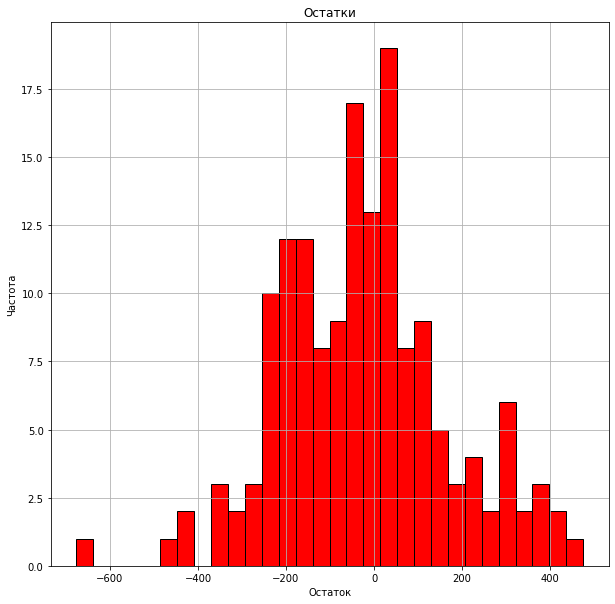

0.8180879926867504

In [100]:
threshold_spo = 0.92
fm['спо high'] = (fm['спо (сахаро-протеиновое соотношение)'] > threshold_spo).astype(int)
fm['эке sq'] = fm['эке (энергетическая кормовая единица)'] ** 2

feature_cols = ['возраст', 'порода папы быка', 'эке sq', 'сырой протеин, г', 'спо high', 'тип пастбища', 'порода']
X = fm[feature_cols]
y = fm['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cat_cols = ['возраст', 'порода папы быка', 'тип пастбища', 'порода']
num_cols = ['эке sq', 'сырой протеин, г', 'спо high']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
X_train_ohe2 = encoder.fit_transform(X_train[cat_cols])
X_test_ohe2 = encoder.transform(X_test[cat_cols])

scaler = StandardScaler()
X_train_scaled2 = scaler.fit_transform(X_train[num_cols])
X_test_scaled2 = scaler.transform(X_test[num_cols])

X_train_prepared2 = np.hstack([X_train_scaled2, X_train_ohe2])
X_test_prepared2 = np.hstack([X_test_scaled2, X_test_ohe2])

model_lr2 = LinearRegression()
model_lr2.fit(X_train_prepared2, y_train)
y_pred2 = model_lr2.predict(X_test_prepared2)
y_resi2 = y_test - y_pred2

plt.figure(figsize=(10, 10))
plt.hist(y_resi2, bins=30, color='red', edgecolor='black')
plt.title('Остатки')
plt.xlabel('Остаток')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

r2 = r2_score(y_test, y_pred2)
r2

**Вывод**: Значение `R2` увеличилось и стало 0.82. График распределения остатков все еще имеет выбросы в левой части, все еще не симметричен, но уже имеет пики около нуля.

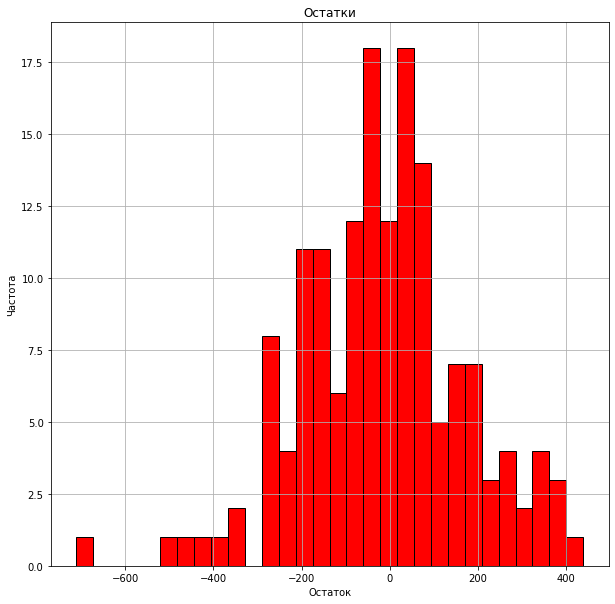

0.8265123645098966

In [101]:
fm = fm.merge(fd[['id', 'имя папы']], on='id', how='left')
threshold_spo = 0.92
fm['спо high'] = (fm['спо (сахаро-протеиновое соотношение)'] > threshold_spo).astype(int)
fm['эке sq'] = fm['эке (энергетическая кормовая единица)'] ** 2

feature_cols = ['возраст', 'эке sq', 'сырой протеин, г', 'спо high', 'тип пастбища', 'порода', 'имя папы']
X = fm[feature_cols]
y = fm['удой, кг']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cat_cols = ['возраст', 'порода', 'тип пастбища', 'имя папы']
num_cols = ['эке sq', 'сырой протеин, г', 'спо high']

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
X_train_ohe3 = encoder.fit_transform(X_train[cat_cols])
X_test_ohe3 = encoder.transform(X_test[cat_cols])

scaler = StandardScaler()
X_train_scaled3 = scaler.fit_transform(X_train[num_cols])
X_test_scaled3 = scaler.transform(X_test[num_cols])

X_train_prepared3 = np.hstack([X_train_scaled3, X_train_ohe3])
X_test_prepared3 = np.hstack([X_test_scaled3, X_test_ohe3])

model_lr3 = LinearRegression()
model_lr3.fit(X_train_prepared3, y_train)
y_pred3 = model_lr3.predict(X_test_prepared3)
y_resi3 = y_test - y_pred3

plt.figure(figsize=(10, 10))
plt.hist(y_resi3, bins=30, color='red', edgecolor='black')
plt.title('Остатки')
plt.xlabel('Остаток')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

r2 = r2_score(y_test, y_pred3)
r2

**Вывод**: Значение `R2` немного увеличилось до 0.83. График стал немного симметричнее, но все также с выбросами.

### 5.4 Сравнение трёх моделей
#### R2 значение
- Значение R2 у 1-ой модели = 0.71
- Значение R2 у 2-ой модели = 0.82
- Значение R2 у 3-ей модели = 0.83
- **Итог**: Лучшее значение R2 показала 3-ья модель, а худшее - 1-ая

#### Распределение остатков
- График распредления остатков 1-ой модели показал выбросы, наличие пика в нуле, но также был другой более высокий пик слева.
- График остатков 2-ой модели показал уже наличие пика около 0, но график все также содержал выбросы и был не симметрично распределен относительно нуля
- График остатков 3-ей же модели показал, что распределение все также имеет выбросы, но стало чуть более симметричным относительно нуля, а также пик значений стал ближе к центру(к 0).
- **Итог**: Наиболее благоприятный график распредления остатков имеет 3-ья модель.

### 5.5 

In [102]:
mse1 = mean_squared_error(y_test, y_pred1)
rmse1 = mean_squared_error(y_test, y_pred1, squared=False)
mae1 = mean_absolute_error(y_test, y_pred1)
errors = y_test - y_pred1
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")
display('mse 1 модели', mse1)
display('rmse 1 модели', rmse1)
'mae 1 модели', mae1

Доверительный интервал прогноза: [-402.9079308679507, 420.1994183602995]


'mse 1 модели'

43887.015009660514

'rmse 1 модели'

209.4922791170608

('mae 1 модели', 164.2419446347492)

In [103]:
mse2 = mean_squared_error(y_test, y_pred2)
rmse2 = mean_squared_error(y_test, y_pred2, squared=False)
mae2 = mean_absolute_error(y_test, y_pred2)
errors = y_test - y_pred2
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")
display('mse 2 модели', mse2)
display('rmse 2 модели', rmse2)
'mae 2 модели', mae2

Доверительный интервал прогноза: [-366.7256395800551, 382.55387804812204]


'mse 2 модели'

37030.91131113691

'rmse 2 модели'

192.4341739690144

('mae 2 модели', 149.03965222364593)

In [104]:
mse3 = mean_squared_error(y_test, y_pred3)
rmse3 = mean_squared_error(y_test, y_pred3, squared=False)
mae3 = mean_absolute_error(y_test, y_pred3)
errors = y_test - y_pred3
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")
display('mse 3 модели', mse3)
display('rmse 3 модели', rmse3)
'mae 3 модели', mae3

Доверительный интервал прогноза: [-393.154486388537, 357.6000355512234]


'mse 3 модели'

35316.00436000985

'rmse 3 модели'

187.92552876075632

('mae 3 модели', 144.6381370452686)

### Качество моделей регрессии

- **1 модель:** MSE = 43887, RMSE = 209.5, MAE = 164.2
- **2 модель:** MSE = 37030, RMSE = 192.4, MAE = 149.0
- **3 модель:** MSE = 35316, RMSE = 187.9, MAE = 144.6

Лучшие результаты показала **третья модель**, обладающая минимальными ошибками на тестовой выборке. Доверительный интервал прогноза удоя по этой модели — примерно от –393 до 358 кг.

### 5.6

In [105]:
mean_eke = fm['эке (энергетическая кормовая единица)'].mean()*1.05
mean_spo = fm['спо (сахаро-протеиновое соотношение)'].mean()*1.05
mean_pro = fm['сырой протеин, г'].mean()*1.05

cb['эке (энергетическая кормовая единица)'] = mean_eke
cb['спо (сахаро-протеиновое соотношение)'] = mean_spo
cb['сырой протеин, г'] = mean_pro

threshold_spo = 0.92
cb['спо high'] = (cb['спо (сахаро-протеиновое соотношение)'] > threshold_spo).astype(int)
cb['эке sq'] = cb['эке (энергетическая кормовая единица)'] ** 2

cat_cols = ['возраст', 'порода', 'тип пастбища', 'имя папы']
num_cols = ['эке sq', 'сырой протеин, г', 'спо high']

cb_ohe = encoder.transform(cb[cat_cols])
cb_scaled = scaler.transform(cb[num_cols])
cb_prep = np.hstack([cb_scaled, cb_ohe])
cb['predicted udoy'] = model_lr3.predict(cb_prep)

cb.head(15)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,порода,тип пастбища,порода папы быка,имя папы,"текущая жирность,%","текущий уровень белок,%",возраст,эке (энергетическая кормовая единица),спо (сахаро-протеиновое соотношение),"сырой протеин, г",спо high,эке sq,predicted udoy
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6559.444516
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6334.275064
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6281.140194
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6543.028775
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6543.028775
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.053,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6380.167370
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6528.290493
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6349.013347
10,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.055,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6289.845052
11,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.73,3.073,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6574.182798


**Комментарий**: Теперь в датафрейме `cb` есть столбец `predicted udoy`, в котором содержится спрогнозированный удой каждой коровы из датафрейма.

## Обучение модели логистической регрессии

### 6.1

In [106]:
X = fm.drop('вкус молока', axis=1)
y = fm['вкус молока']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
cat_cols = ['порода', "тип пастбища", "порода папы быка", "возраст", "имя папы"]
num_cols = ["удой, кг", "эке (энергетическая кормовая единица)", "сырой протеин, г", 
           "спо (сахаро-протеиновое соотношение)", "жирность,%", "белок,%", "спо high", "эке sq"]

y = y.apply(lambda x: 1 if x == 'вкусно' else 0)

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_train_ohe = encoder.fit_transform(X_train[cat_cols])
X_test_ohe = encoder.transform(X_test[cat_cols])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

X_train_prepared = np.hstack([X_train_scaled, X_train_ohe])
X_test_prepared = np.hstack([X_test_scaled, X_test_ohe])
clf = LogisticRegression()
clf.fit(X_train_prepared, y_train)

y_pred = clf.predict(X_test_prepared)
accuracy = accuracy_score(y_test, y_pred)
recall    = recall_score(y_test,    y_pred, pos_label='вкусно')
precision = precision_score(y_test, y_pred, pos_label='вкусно')
cm = confusion_matrix(y_test, y_pred, labels=['вкусно','не вкусно'])
display('accuracy', accuracy)
display('recall', recall)
display('precision', precision)
display('confusion matrix', cm)

'accuracy'

0.6878980891719745

'recall'

0.9090909090909091

'precision'

0.6611570247933884

'confusion matrix'

array([[80,  8],
       [41, 28]])

**Комментарий**: Точность модели (`accuracy`) составляет 69%.
Модель ошибочно присваивает метку вкусно невкусному молоку в 34% случаев. Также в 9% случаев происходит наоборот — модель присваивает метку не вкусно вкусному молоку

### 6.2

**Пояснение критичности ошибки первого или второго рода**: Т.к. для клиента важно чтобы молоко было вкусно, нам нельзя допустить чтобы ему попалось корова дающая невкусное молоко, следовательно в этом случае критичной ошибкой будет ошибка первого рода. Для фермера важно чтобы из всех купленных коров все давали вкусное молоко, значит важно чтобы значение `precision` было равно 1.

**Изменение порога вхождения в класс**

In [107]:
th = 0.5
while True:
    th += 0.001
    pred_bool = (clf.predict_proba(X_test_prepared)[:, 0] >= th)
    pred = np.where(pred_bool, 'вкусно', 'не вкусно')
    if precision_score(y_test, pred, pos_label='вкусно') == 1:
        break
th

0.8100000000000003

**Комментарий**: Нашли пороговое значение, его и берем

In [108]:
probas = clf.predict_proba(X_test_prepared)[:, 0]
threshold = 0.8100000000000003
y_pred_custom = ['вкусно' if p > threshold else 'не вкусно' for p in probas]
precision = precision_score(y_test, y_pred_custom, pos_label='вкусно')
recall = recall_score(y_test, y_pred_custom, pos_label='вкусно')
accuracy = accuracy_score(y_test, y_pred_custom)
cm = confusion_matrix(y_test, y_pred_custom, labels=['вкусно','не вкусно'])
display('precision', precision)
display('recall', recall)
display('accuracy', accuracy)
display('confusion matrix', cm)

'precision'

1.0

'recall'

0.1590909090909091

'accuracy'

0.5286624203821656

'confusion matrix'

array([[14, 74],
       [ 0, 69]])

**Комментарий**: Было взято пороговое значение 0.8100000000000003, при котором модель ни разу не ошиблась в опредлении вкусного молока.

**Что делать дальше**: 
```
- Найти оптимальный порог вероятности для максимизации precision.
- Поробовать добавить новые признаки.
- Увеличить объём данных.
```

### 6.3

In [114]:
cat_cols = ['порода', "тип пастбища", "порода папы быка", "возраст", "имя папы"]
num_cols = ["predicted udoy", "эке (энергетическая кормовая единица)", "сырой протеин, г", 
           "спо (сахаро-протеиновое соотношение)", "текущая жирность,%", "текущий уровень белок,%", "спо high", "эке sq"]

cb_ohe_clf = encoder.transform(cb[cat_cols])
cb_scaled_clf = scaler.transform(cb[num_cols])
cb_prep_clf = np.hstack([cb_scaled_clf, cb_ohe_clf])
probas = clf.predict_proba(cb_prep_clf)[:, 0]
threshold = 0.8100000000000003
cb['predicted taste'] = ['вкусно' if p > threshold else 'не вкусно' for p in probas]

cb['predicted taste'].value_counts()

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predicted udoy
- текущая жирность,%
- текущий уровень белок,%
Feature names seen at fit time, yet now missing:
- белок,%
- жирность,%
- удой, кг

  warnings.warn(message, FutureWarning)


не вкусно    10
вкусно        6
Name: predicted taste, dtype: int64

**Комментарий**: Модель показала что в cb 6 коров дают вкусное молоко.

# Итоговый вывод

In [115]:
cb.loc[(cb['predicted udoy']>6000)&(cb['predicted taste']=='вкусно')]

,порода,тип пастбища,порода папы быка,имя папы,"текущая жирность,%","текущий уровень белок,%",возраст,эке (энергетическая кормовая единица),спо (сахаро-протеиновое соотношение),"сырой протеин, г",спо high,эке sq,predicted udoy,predicted taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6559.444516,вкусно
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6334.275064,вкусно
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6281.140194,вкусно
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.079,более_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6528.290493,вкусно
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6349.013347,вкусно
13,Вис Бик Айдиал,холмистое,Соверин,Барин,3.42,3.075,менее_2_лет,15.276162,0.958744,2019.947532,1,233.361138,6072.386483,вкусно


**Комменатрий**: Были отобраны коровы с удоем более 6000 кг и вкусным молоком

## Итоговые выводы

В рамках проекта была построена система отбора коров для фермерского хозяйства по двум ключевым критериям:
- средний удой более **6000 кг** в год;
- вкусное молоко по оценке заказчика.

### Результаты моделей

- **Лучшая модель регрессии** (предсказание удоя):  
  - R²: 0.83
  - MAE: 144.6
  - RMSE: 187.9

- **Лучшая модель классификации** (предсказание вкуса молока):  
  - Accuracy: 0.53  
  - Precision: 1  
  - Recall: 0.16

### Отбор коров

- Из всего стада на продажу отобрано **6** коров, которые соответствуют обоим условиям (удой > 6000 кг и вкусное молоко).
- Это позволяет фермеру купить животных с минимальным риском не выполнить план по производству и качеству молока.

### Рекомендации фермеру

- Обращать внимание на возраст коровы и корм, которым ее кормят.
- Возможные направления для дальнейшего улучшения моделей: добавить новые признаки, использовать более сложные алгоритмы и т.д.
- Оценивать экономические риски не только по удою, но и по вероятности получения вкусного молока.

---